In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers import RNN
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers import LSTM

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

Using TensorFlow backend.


## Read in Data

In [2]:
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000]
e_train = df.iloc[20000:]

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
# LAE: added .values before reshape due to pandas naming deprecation
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Create and Train Model

In [4]:
def train_model(x, y, LSTM_units=10, layers=3, dense_nodes=20,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    
    model = Sequential()
    
    # LSTM recurrent layers
    model.add(LSTM(LSTM_units,input_shape=(50,4),return_sequences=True)) # 50 "time steps", 4 features (one-hot ATGC encode)
    model.add(Dropout(dropout1))
    model.add(LSTM(LSTM_units,input_shape=(50,4)))
    
    # fully-connected linear layer
    model.add(Dense(dense_nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    # final linear classifier
    model.add(Dense(1))
    model.add(Activation('linear'))
    
    
    # Compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model

In [5]:
model = train_model(seq_e_train, e_train['scaled_rl'], LSTM_units=16, dense_nodes=40, nb_epoch=3)

W0815 10:34:43.463177 4422813120 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 10:34:43.504651 4422813120 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 10:34:43.532083 4422813120 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0815 10:34:43.875863 4422813120 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0815 10:34:44.103984 4422813120 deprecation.py:323] From /usr/local/lib/pyt

Epoch 1/3
260000/260000 [==============================] - 151s 582us/step - loss: 0.7865 - acc: 0.0000e+00
Epoch 2/3
260000/260000 [==============================] - 150s 577us/step - loss: 0.4875 - acc: 0.0000e+00
Epoch 3/3
260000/260000 [==============================] - 149s 572us/step - loss: 0.4500 - acc: 0.0000e+00


In [11]:
e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print 'r-squared = ', r

r-squared =  0.9264159387010185


In [7]:
#model.save('./saved_models/rnn_model_big.hdf5')

## Plotting Results

In [9]:
model = keras.models.load_model('./saved_models/rnn_model_big.hdf5')

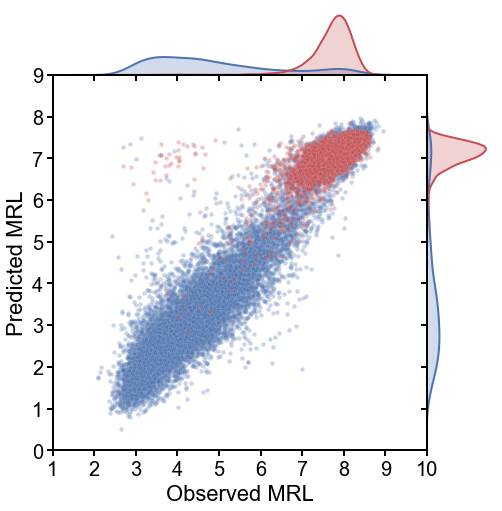

In [12]:
atg = e_test[e_test['utr'].apply(lambda x: 'ATG' in x)]
n_atg = e_test[e_test['utr'].apply(lambda x: 'ATG' not in x)]

c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='rl', y="pred", data=atg, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha='0.3', edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(0,9.01, 1));
ax.set_yticklabels(range(10),size=20);
ax.set_xticks(np.arange(1,10.01, 1));
ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(0,9)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = n_atg['rl'].values
g.y = n_atg['pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha='0.3', color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig

In [13]:
off_diagonals = e_test[(e_test['rl']<4.6)&(e_test['pred']>5.4)]
len(off_diagonals)

50

In [14]:
off_diagonals.head(10)

,Unnamed: 0,utr,0,1,2,3,4,5,6,7,...,r6,r7,r8,r9,r10,r11,r12,r13,rl,pred
8,112852,GATACGCATAAACGTTCCATGCTATGGTATGGCCCCTCAAGGCGCTATCC,0.000046,0.000050,0.000055,0.000048,0.000024,0.000021,0.000011,0.000011,...,0.032716,0.030775,0.029643,0.035778,0.038631,0.038631,0.038794,0.043036,4.224131,6.371667
246,228050,GCCGCACCGGCCCTCAATGCAGGACAAGGATGATGAAGAGATGGACAGCA,0.000052,0.000043,0.000031,0.000019,0.000008,0.000009,0.000007,0.000004,...,0.031954,0.020909,0.022948,0.028113,0.034912,0.034912,0.040339,0.023895,3.387047,5.531667
999,226582,AGCTTACTGAACCTGGTCGTGGAGGTATGCAGGAGGTATGTGCATGCCTG,0.000034,0.000036,0.000025,0.000013,0.000009,0.000009,0.000005,0.000006,...,0.029120,0.031509,0.030538,0.026672,0.043827,0.043827,0.042533,0.051309,4.065457,6.047128
1046,89012,GCGAGGGAACAAGAGCAAAGGAGAATCTAGGCCACATCTCTCGTCGTTCC,0.000024,0.000037,0.000028,0.000015,0.000011,0.000009,0.000006,0.000006,...,0.033772,0.035514,0.035510,0.033592,0.039144,0.039144,0.038410,0.035048,4.038996,7.039894
1909,232479,ACAAAAACATTGACATGATCGGATACAGGCGGCGTACGGCATGCGCTACC,0.000030,0.000032,0.000024,0.000016,0.000008,0.000007,0.000004,0.000004,...,0.025004,0.026887,0.025049,0.024521,0.045485,0.045485,0.032901,0.031797,3.715876,6.539258
3279,115533,CACCGAGTCTTGCGGCCTAAATCCGTAGGGGTCTGGGTCCACGATTGTCC,0.000036,0.000031,0.000018,0.000009,0.000006,0.000007,0.000004,0.000004,...,0.027872,0.029664,0.025882,0.026299,0.035648,0.035648,0.031976,0.037537,3.450179,6.480992
3467,232027,CCATCAATTTATCACATAAAGCCCTGTGTGGGTTGTCTGCGCATACAGAA,0.000029,0.000028,0.000017,0.000010,0.000006,0.000006,0.000005,0.000005,...,0.031692,0.037771,0.034125,0.037183,0.047723,0.047723,0.039136,0.056973,4.217225,7.290131
3582,90322,CGCGCCGAACGCGCGACAAGCAAAGCACGACAGAACGTGCCCACTAAAGC,0.000035,0.000032,0.000018,0.000008,0.000007,0.000006,0.000005,0.000004,...,0.032290,0.026047,0.023872,0.028277,0.034306,0.034306,0.025561,0.041463,3.419108,6.667945
3974,265040,CCAGAAGATACAACCCGGGATTACTGGCGGTCCGATTAGAACTGATCAAG,0.000033,0.000034,0.000017,0.000010,0.000005,0.000005,0.000004,0.000004,...,0.025660,0.025103,0.025401,0.027429,0.032515,0.032515,0.039899,0.053005,3.598649,7.336060
4049,157141,CCTGCGTCTAGCCGGTGCGTGTAACGAATATCCTACCGTTGAAATACTAC,0.000029,0.000027,0.000019,0.000012,0.000005,0.000006,0.000003,0.000004,...,0.022889,0.029767,0.028933,0.027242,0.050658,0.050658,0.038351,0.045245,3.974110,7.032732


In [15]:
#off_diagonals.to_csv('../off_diagonal_RNN_utrs.csv')